In [1]:
class ExposureFilter:
    def __init__(self,img, acceleration_voltage, critical_dose_scaling, critical_dose_power, critical_dose_a, critical_dose_b,critical_dose_c, voltage_scaling_factor):
        self.img = img
        self.acceleration_volatage = acceleration_voltage
        self.critical_dose_scaling = critical_dose_scaling
        self.critical_dose_power = critical_dose_power
        self.critical_dose_a = critical_dose_a
        self.critical_dose_b = critical_dose_b
        self.critical_dose_c = critical_dose_c
        self.voltage_scaling_factor = voltage_scaling_factor
    def DoseFilter(self,dose_at_end_of_frame, critical_dose):
        #compute dose filter, which is the signal attenuation factor due to radiation damage
        dose_filter = np.exp((-0.5*dose_at_end_of_frame)/critical_dose)
        return dose_filter
    def CriticalDose(self, spatial_frequency):
        #given a spatial frequency, return the critical dose in electrons per square angstroms
        critical_dose = (self.critical_dose_a*(spatial_frequency**self.critical_dose_b)+self.critical_dose_c)*self.voltage_scaling_factor
        return critical_dose
    def SignalToNoiseFromDoseGivenCriticalDose(self, dose, critical_dose):
        #given a number of electrons and a critical dose, return the snr
        if dose == 0.0:
            snr = 0.0
        else:
            snr = (1-np.exp(-dose*0.5/critical_dose))**2/dose
        return snr
    def OptimalDoseGiven(self,critical_dose):
        #given the critical dose, return an estimate of the optimal dose
        optimal_dose = 2.51284 * critical_dose
        return optimal_dose
    def GetDoseFilter(self, dose_start, dose_finish):
        #apply dose filter to the image
        num_of_img = self.img.allimg().shape[0]
        dose_per_frame = (dose_finish-dose_finish)/num_of_img
        current_critical_dose = 0
        critical_dose_at_dc = 10e35
        all_filters = np.zeros([num_of_img, self.img.allimg().shape[1],self.img.allimg().shape[2]])
        all_fft = np.zeros([num_of_img, self.img.allimg().shape[1],self.img.allimg().shape[2]], dtype=np.complex_)
        for i in range(num_of_img):
            print(i)
            dose_finish += dose_per_frame
            #do FFT of the image
            single_frame = self.img.allimg()[i]
            F = fft2(single_frame)
            F = fftshift(F)
            xfreq = np.fft.fftfreq(single_frame.shape[0],d = self.img.pixel_distance())
            xfreq = fftshift(xfreq)
            yfreq = np.fft.fftfreq(single_frame.shape[1],d = self.img.pixel_distance())
            yfreq = fftshift(yfreq)
            yfreq = yfreq*(-1)
            for j in range(len(xfreq)):
                for k in range(len(yfreq)):
                    if xfreq[j] == 0.0 and yfreq[k] == 0.0:
                        current_critical_dose = critical_dose_at_dc
                    else:
                        current_critical_dose = self.CriticalDose(np.sqrt(xfreq[j]**2+yfreq[k]**2))
                    current_optimal_dose = self.OptimalDoseGiven(current_critical_dose)
                    #print(current_critical_dose)
                    #if (abs(dose_finish-current_optimal_dose) < abs(dose_start-current_optimal_dose)):
                    if True:
                        dose_filter = self.DoseFilter(dose_finish, current_critical_dose)
                        #print(dose_filter)
                        all_filters[i,j,k] = dose_filter
                        new_val = dose_filter * F[j,k]
                        all_fft[i,j,k] = new_val
                    else:
                        all_filters[i,j,k] = 0
                        all_fft[i,j,k] = 0
            dose_start += dose_per_frame
        return all_filters, all_fft
        

In [2]:
import numpy as np
import scipy.fftpack as spf
from numpy.fft import fft2, fftshift, ifft2,ifftshift
import mrcfile
import cv2
from scipy import misc

In [3]:
class MovieImage:
    def __init__(self, mrcfile, pixel_spacing, acceleration_voltage):
        self.mrcfile = mrcfile
        self.pixel_spacing = pixel_spacing
        self.acceleration_voltage = acceleration_voltage
    def allimg(self):
        with mrcfile.open(self.mrcfile) as f:
            movie = f.data
        return movie
    def pixel_distance(self):
        return self.pixel_spacing

In [ ]:
sum_fft = np.sum(all_fft, axis = 0)
denom = np.sqrt(np.sum(np.power(all_filters, 2), axis = 0))
final_fft = np.divide(sum_fft, denom)
final_fft = ifftshift(final_fft)
final = ifft2(final_fft)

In [4]:
#Calculate structure tensor
import cv2 as cv
import numpy as np
import argparse
W = 52          # window size is WxW
C_Thr = 0.43    # threshold for coherency
LowThr = 35     # threshold1 for orientation, it ranges from 0 to 180
HighThr = 57    # threshold2 for orientation, it ranges from 0 to 180
def calcGST(inputIMG, w):
    img = inputIMG.astype(np.float32)
    # GST components calculation (start)
    # J =  (J11 J12; J12 J22) - GST
    imgDiffX = cv.Sobel(img, cv.CV_32F, 1, 0, 3)
    imgDiffY = cv.Sobel(img, cv.CV_32F, 0, 1, 3)
    imgDiffXY = cv.multiply(imgDiffX, imgDiffY)
    
    imgDiffXX = cv.multiply(imgDiffX, imgDiffX)
    imgDiffYY = cv.multiply(imgDiffY, imgDiffY)
    J11 = cv.boxFilter(imgDiffXX, cv.CV_32F, (w,w))
    J22 = cv.boxFilter(imgDiffYY, cv.CV_32F, (w,w))
    J12 = cv.boxFilter(imgDiffXY, cv.CV_32F, (w,w))
    return J11, J22, J12

In [37]:
class PixelOperation:
    def __init__(self, J11, J12, J22):
        self.J11 = J11
        self.J12 = J12
        self.J22 = J22

    def gst(self):
        gst_mat = np.array([[self.J11, self.J12],[self.J12, self.J22]])
        return gst_mat
    def DirectionVector(self, gst):
        #each column is an eigenvector
        w,v = np.linalg.eig(gst)
        #print(w)
        return w, v
    def ComputeKs(self, w, v, kdetail, kshrink, kstretch, knoise, Dth, Dtr):
        A = 1+np.sqrt(w[0]/w[1])
        D = clamp(1-np.sqrt(w[0])/Dtr,0,1)
        k1hat = kdetail*(kstretch*A)
        k2hat = kdetail/(kshrink*A)
        k1 = ((1-D)*k1hat+D*kdetail*knoise)**2
        k2 = ((1-D)*k2hat+D*kdetail*knoise)**2
        return k1, k2
    def ComputeO(self, k1, k2, v):
        kmat = np.diag([k1, k2])
        o1 = np.matmul(v, kmat)
        o2 = np.matmul(o1, np.transpose(v))

        invo2 = np.linalg.pinv(o2)
        return invo2
        
        

In [36]:
#confidence in interpolation & actual shifts?

In [6]:
class ImageOperation:
    def __init__(self, img_stack):
        self.img_stack = img_stack
    def SlidingWindow(self,image, stepSize, windowSize):
    # slide a window across the image
        for y in range(1, image.shape[0]-1, stepSize):
            for x in range(1, image.shape[1]-1, stepSize):
            # yield the current window
                yield (x, y, image[y-windowSize[1]//2:y + windowSize[1]//2+1, x-windowSize[0]//2:x + windowSize[0]//2+1])
    def CalcMeanStd(self, stepSize, windowSize):
        num_of_img = self.img_stack.shape[0]
        pixel_mean = self.img_stack.copy()
        pixel_std = self.img_stack.copy()
        for i in range(num_of_img):
            single_img = self.img_stack[i]
            single_img = np.pad(single_img,((1,1),(1,1)), 'constant')
            #print(single_img)
            for (x, y, window) in self.SlidingWindow(single_img, stepSize=stepSize, windowSize= windowSize):
                #print(window)
                #print(x)
                #print(y)
                window_mean = np.mean(window)
                window_std = np.std(window)
                pixel_mean[i, y-1, x-1] = window_mean
                pixel_std[i, y-1, x-1] = window_std
        return pixel_mean, pixel_std
    def CalcDiff(self, pixel_mean, pixel_std):
        num_of_img = pixel_mean.shape[0]
        base_mean = pixel_mean[0,:,:]
        dms = pixel_mean.copy()
        dmd = pixel_mean.copy()
        for i in range(num_of_img):
            current_mean = pixel_mean[i,:,:]
            other_means = pixel_mean[np.arange(num_of_img)!=i,:,:]
            #print(other_means.shape)
            other_mean_mean = np.mean(other_means, axis = 0)
            dms[i,:,:] = current_mean - other_mean_mean
            dmd[i,:,:] = current_mean - base_mean
        return dms, dmd
    
    def FinalD(self, dms, dmd):
        dms2 = np.power(dms,2)
        dmd2 = np.power(dmd, 2)
        frac = dms2/(dms2+dmd2)
        d = dms*frac
        return d
    
    def RelativeS(self, error, row, col, thre, s1, s2):
        #s1 = 12, s2 = 2
        all_s = self.img_stack.copy()
        num_of_imgs = error.shape[0]
        total_patches = error.shape[1]
        patch_row_width = self.img_stack.shape[1]//row
        #print(patch_row_width)
        patch_col_width = self.img_stack.shape[2]//col
        for i in range(num_of_imgs):
            it = 0
            for j in range(row):
                for k in range(col):
                    #print(error[i, it])
                    if error[i, it] >= thre:
                        s = s1
                    else:
                        s = s2
                    all_s[i,j*patch_row_width:(j+1)*patch_row_width, k*patch_col_width:(k+1)*patch_col_width] = s
                    it += 1
        return all_s
    
    def CalcR(self, s, d, sig, t):
        R = s*np.exp(-(np.power(d, 2)/np.power(sig, 2)))-t
        return R
    
                    
            
        

In [7]:
window_dis = np.array([[-1,-1],[0,-1],[1,-1],[-1,0],[0,0],[1,0],[1,1],[1,0],[1,1]])


In [213]:
np.transpose(window_dis[0]).shape

(2,)

In [42]:
def Merge(img_stack, R, J11, J12, J22,kdetail, kshrink, kstretch, knoise, Dth, Dtr):
    #padding image and R for boundary cases
    num_of_img = img_stack.shape[0]
    merged_img = np.zeros([img_stack.shape[1],img_stack.shape[2]])
    r = img_stack.shape[1]
    c = img_stack.shape[2]
    padded_img = np.pad(img_stack,((0,0),(1,1),(1,1)),'constant')
    padded_R = np.pad(R, ((0,0),(1,1),(1,1)),'constant')
    for i in range(1, padded_img.shape[1]-1):
        for j in range(1, padded_img.shape[2]-1):
            numerator = 0
            denom = 0
            for k in range(num_of_img):
                #print(k)
                pix_J11 = J11[k,i-1,j-1]
                pix_J12 = J12[k,i-1,j-1]
                pix_J22 = J22[k,i-1,j-1]
                pix_op = PixelOperation(pix_J11, pix_J12, pix_J22)
                pix_gst = pix_op.gst()
                w,v = pix_op.DirectionVector(pix_gst)
                k1, k2 = pix_op.ComputeKs(w,v,kdetail, kshrink, kstretch, knoise, Dth, Dtr)
                invo = pix_op.ComputeO(k1, k2, v)
                ws = np.zeros(9)
                for it, dis in enumerate(window_dis):
                    mult = np.matmul(np.matmul(dis, invo), dis)
                    w_i = np.exp(-0.5*mult)
                    ws[it] = w_i
                ws = ws.reshape([3,3])
                #print(invo)
                #print(ws)
                img_win = padded_img[k,i-1:i+2, j-1:j+2]
                R_win = padded_R[k,i-1:i+2, j-1:j+2]
                #print(R_win)
                num = ws*img_win*R_win
                den = ws*R_win
                num = np.sum(num)
                den = np.sum(den)
                numerator += num
                denom += den
            #print(denom)
            merged_img[i-1,j-1] = numerator/denom
    return merged_img
                
                

In [66]:
J11.shape

(3, 2400, 2480)

In [14]:
test_img = dat[10:13]
interpolated_test_img = np.zeros([test_img.shape[0],test_img.shape[1]*2, test_img.shape[2]*2])
for i in range(test_img.shape[0]):
    interpolated = cv2.resize(test_img[i], (test_img.shape[2]*2, test_img.shape[1]*2))
    print(interpolated.shape)
    interpolated_test_img[i,:,:] = interpolated

(2400, 2480)
(2400, 2480)
(2400, 2480)


In [24]:
f = e[10:13,:]

In [15]:
op = ImageOperation(interpolated_test_img)

In [27]:
J11 = interpolated_test_img.copy()
J12 = interpolated_test_img.copy()
J22 = interpolated_test_img.copy()
for i in range(interpolated_test_img.shape[0]):
    j11s,j22s,j12s = calcGST(interpolated_test_img[i,:,:], 7)
    print(j11s.shape)
    J11[i,:,:] = j11s
    J12[i,:,:] = j12s
    J22[i,:,:] = j22s


(2400, 2480)
(2400, 2480)
(2400, 2480)


In [28]:
kdetail = 0.25
kshrink = 2
kstretch = 4
knoise = 3.0
Dth = 0.001
Dtr = 0.003

In [18]:
pixel_mean, pixel_std = op.CalcMeanStd(1, [3,3])

In [29]:
dms, dmd = op.CalcDiff(pixel_mean,pixel_std)

In [30]:
d = op.FinalD(dms, dmd)

In [31]:
s = op.RelativeS(f, 5, 5, 0.5, 12, 2)

In [32]:
R = op.CalcR(s, d, pixel_std, 0)

In [43]:
merged = Merge(interpolated_test_img, R, J11, J12, J22,kdetail, kshrink, kstretch, knoise, Dth, Dtr)

In [53]:
merged

array([[18.70401256, 18.74117642, 17.56845475, ..., 11.00912896,
         8.74871106,  7.80906026],
       [18.44000235, 18.76107968,  3.71947899, ...,  9.94181768,
         7.89197359,  7.66599747],
       [12.55757806,  9.54900614,  5.14309095, ..., 10.03808536,
         8.14661857,  7.72722602],
       ...,
       [ 8.53618836,  4.98199637,  2.95475845, ..., 10.70818332,
         8.92912672,  8.73118652],
       [ 5.77561205,  5.99443063,  6.58439076, ...,  9.11686454,
         5.79849084,  3.96429219],
       [ 4.84765769,  5.57037285,  6.6283527 , ...,  9.78475046,
         4.05794595,  1.08818399]])

In [49]:
orig = np.sum(interpolated_test_img, axis = 0)

In [52]:
orig

array([[18.61560941, 18.61560893, 18.61560583, ..., 28.16994596,
        23.52520609, 21.20283771],
       [18.61560893, 18.61560917, 18.61560702, ..., 28.16994405,
        23.52520609, 21.20283771],
       [18.61560988, 18.61561084, 18.61561298, ..., 28.16994047,
        23.52520585, 21.20283961],
       ...,
       [22.43213415, 21.37270689, 19.25385571, ..., 21.46356964,
        22.79687977, 23.46353483],
       [16.48593521, 17.53697443, 19.6390543 , ..., 22.30476761,
        13.66184139,  9.34037733],
       [13.51283658, 15.61910868, 19.83165312, ..., 22.72536588,
         9.09432149,  2.27879959]])

In [50]:
orig.shape

(2400, 2480)

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt

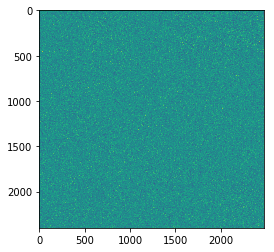

In [47]:
plt.imshow(merged)

In [48]:
plt.imsave('merged.png',merged)

In [51]:
plt.imsave('orig.png',orig)

In [34]:
pixel_mean

array([[[ 0.98049982,  1.47074983,  1.80716491, ...,  2.00209392,
          1.63123714,  0.76900276],
        [ 1.47074978,  2.20612489,  2.71074759, ...,  3.00314101,
          2.44685576,  1.15350416],
        [ 2.0583348 ,  3.08750253,  3.50406641, ...,  3.06953825,
          2.69930747,  1.44309571],
        ...,
        [ 5.98370308,  8.97555452,  8.71861802, ...,  5.21839841,
          3.86682232,  2.10188195],
        [ 4.79638518,  7.19457759,  6.79201966, ...,  4.19264041,
          2.73122009,  1.34554538],
        [ 2.49330325,  3.73995468,  3.43045746, ...,  2.31637398,
          1.22102664,  0.47118084]],

       [[ 8.3384374 , 12.50765567, 12.07090123, ...,  6.45342308,
          5.48829089,  3.2790237 ],
        [12.50765652, 18.76148436, 18.10635291, ...,  9.68013398,
          8.23243602,  4.9185356 ],
        [11.85165162, 17.77747726, 17.19204066, ...,  9.35758215,
          8.22668256,  5.06044186],
        ...,
        [ 0.10805443,  0.1620814 ,  0.72844047, ..., 1

In [37]:
f = e[10:13,:]

In [157]:
g = op.RelativeS(f, 5, 5, 0.5, 12, 2)

240


In [159]:
g[0]

array([[2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       ...,
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.]], dtype=float32)

In [162]:
d = op.FinalD(dms, dmd)

In [191]:
t = op.CalcR(g, d, b, 0)

In [220]:
tt = np.array([[1,2],[1,2]])
np.sum(tt)

6

In [186]:
for i in temp:
    if i == 0.0:
        print(i)

In [165]:
b.shape

(4,)

In [64]:
dat[1].shape

(1200, 1240)

In [166]:
a,b = op.CalcMeanStd(1, [3,3])

In [167]:
b.shape

(3, 1200, 1240)

In [111]:
dms, dmd = op.CalcDiff(a, b)

(2, 1200, 1240)
(2, 1200, 1240)
(2, 1200, 1240)


In [100]:
a

array([[[2.8340154, 4.402512 , 4.857113 , ..., 5.0650735, 5.363048 ,
         3.6990042],
        [4.2448053, 6.4193306, 6.9527874, ..., 7.56953  , 6.8608675,
         4.7777896],
        [4.7603436, 7.170299 , 7.3031135, ..., 6.876983 , 5.9834123,
         4.3043194],
        ...,
        [5.196184 , 6.4443536, 5.01079  , ..., 9.5581875, 9.204361 ,
         5.9337945],
        [4.4948597, 5.8282337, 5.048443 , ..., 8.603766 , 7.260203 ,
         4.7627583],
        [3.4588113, 4.2767367, 3.7229009, ..., 4.8385487, 4.6730022,
         3.2751217]],

       [[1.8706082, 2.4995673, 2.2795591, ..., 3.1695213, 3.7756026,
         2.3772998],
        [2.6048083, 3.4460142, 4.0411015, ..., 4.521162 , 5.236665 ,
         3.3849952],
        [2.1260905, 3.2664418, 5.0861597, ..., 5.5330997, 5.2486806,
         3.4144642],
        ...,
        [4.061677 , 6.326722 , 7.734264 , ..., 4.855673 , 5.3408275,
         3.594126 ],
        [4.438267 , 6.5027137, 7.372564 , ..., 4.264887 , 4.705169 ,
   

In [9]:
def ReadError(file, num_of_frames, num_of_patches):
    errors = np.zeros([num_of_frames, num_of_patches])
    patches = -1
    with open(file,'r') as f:
        for l in f:
            if not l.startswith('#'):
                l = l.split()
                if len(l) == 0:
                    patches += 1
                else:
                    frame = int(l[0])-1
                    measured = np.array([float(l[3]),float(l[4])])
                    interpolated = np.array([float(l[5]),float(l[6])])
                    distance = np.linalg.norm(measured-interpolated)
                    errors[frame,patches] = distance
    f.close()
    return errors
                    

In [22]:
e = ReadError('test.log0-Patch-Patch.log',50,25)

In [11]:
e.shape

(50, 25)

In [12]:
with mrcfile.open('test2_Stk.mrc',permissive=True) as f:
    dat = f.data

/home/wendy/anaconda3/lib/python3.7/site-packages/mrcfile/mrcinterpreter.py:208: RuntimeWarning: Map ID string not found - not an MRC file, or file is corrupt
  warnings.warn(msg, RuntimeWarning)


In [5]:
dat[0:5].shape

(5, 1200, 1240)

In [46]:
dat[0,0,0]

5.422753

In [13]:
def clamp(x, lower, upper):
    if x < lower:
        x = lower
    elif x > upper:
        x = upper
    return x


In [3]:
np.array([[1,2],[2,1]])

array([[1, 2],
       [2, 1]])

In [5]:
u,s,v = np.linalg.svd(np.array([[1,2],[2,1]]))

In [6]:
u

array([[-0.70710678, -0.70710678],
       [-0.70710678,  0.70710678]])

In [10]:
np.diag([5,5])

array([[5, 0],
       [0, 5]])

In [26]:
a = np.zeros([5,5])

In [27]:
a[0] = 5.5

In [28]:
a

array([[5.5, 5.5, 5.5, 5.5, 5.5],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ]])